# Embedding for Sentiment Analysis 

Now that we know how word embedding works, we'll apply it to a supervised problem of sentiment analysis. The idea is to classify the comments left by users according to the number of stars they gave the Disneyland resort park in their reviews.

## Data Preprocessing

### Import Data 

1. Import the following libraries:

* tensorflow 
* pathlib
* pandas 
* os
* io
* `sklearn.model_selection.train_test_split`

In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

2. Copy the link below and read the file it contains with `pandas`.

* https://go.aws/314bBDq

In [2]:
# Import dataset with Pandas 
dataset = pd.read_csv("https://go.aws/314bBDq", error_bad_lines=False, encoding="utf-8")
dataset.head()

,user_id,review,stars,date_format,time_of_day,hour_of_day,day_of_week,review_format,review_lang,month_year,review_len,review_nb_words
0,efb62a167fee5cf3678b24427de8e31f,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,2017-09-29 18:17:00,18:17,18,Ven,génial fabuleux exceptionnel j aimerais qu...,french,2017-09,115,19
1,e3be4f9c9e0b9572bfb2a5f88497bb14,NaN,2,2017-09-29 17:29:00,17:29,17,Ven,NaN,NaN,2017-09,0,0
2,1b8e5760162d867e9b9ca80f645bdc60,"Toujours aussi magic, féerique !",5,2017-09-29 16:46:00,16:46,16,Ven,toujours aussi magic féerique,french,2017-09,32,4
3,fa330e5891a1bb486c3e9bf95c098726,NaN,5,2017-09-29 15:52:00,15:52,15,Ven,NaN,NaN,2017-09,0,0
4,c1a693206aee1a2412d4bd9e45b80ec5,NaN,3,2017-09-29 15:29:00,15:29,15,Ven,NaN,NaN,2017-09,0,0


3. We will need the reviews in French. Filter the reviews so that they are in the right language. For this you need to find a column that gives you that information.

In [3]:
# Taking only french reviews
french_reviews = dataset[dataset.review_lang == "french"]
french_reviews.head()

,user_id,review,stars,date_format,time_of_day,hour_of_day,day_of_week,review_format,review_lang,month_year,review_len,review_nb_words
0,efb62a167fee5cf3678b24427de8e31f,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,2017-09-29 18:17:00,18:17,18,Ven,génial fabuleux exceptionnel j aimerais qu...,french,2017-09,115,19
2,1b8e5760162d867e9b9ca80f645bdc60,"Toujours aussi magic, féerique !",5,2017-09-29 16:46:00,16:46,16,Ven,toujours aussi magic féerique,french,2017-09,32,4
11,726b1a3e2664e8b075129bcd643dbf56,En vacances en région parisienne nous nous som...,2,2017-09-29 00:37:00,00:37,0,Ven,en vacances en région parisienne nous nous som...,french,2017-09,172,25
12,8a71763fbb3da7436b957681b24cc404,Tropbeaufinalpleinlesyeuxoreil,5,2017-09-29 00:16:00,00:16,0,Ven,tropbeaufinalpleinlesyeuxoreil,french,2017-09,30,1
23,ce7abd7798ee036d667c0ad84b85daa7,L'univers Disney reste merveilleux. Toutefois ...,4,2017-09-28 20:24:00,20:24,20,Jeu,l univers disney reste merveilleux toutefois ...,french,2017-09,148,23


4. Keep only the `review` & `stars` columns.

In [4]:
# Let's take the columns we're interested in 
french_reviews = french_reviews[["review", "stars"]]
french_reviews.head()

,review,stars
0,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5
2,"Toujours aussi magic, féerique !",5
11,En vacances en région parisienne nous nous som...,2
12,Tropbeaufinalpleinlesyeuxoreil,5
23,L'univers Disney reste merveilleux. Toutefois ...,4


### Preprocessing

We will now go through a preprocessing phase. The goal is to clean up the character strings and encode the words so they are represented as integers.

1. Use the command: `!python -m spacy download fr_core_news_md` to download all language elements related to the French language

In [5]:
# !python -m spacy download fr_core_news_md -q

2. Load now `fr_core_news_md` into a variable called `nlp`

In [6]:
# Import Spacy and french initialisation
import fr_core_news_md
nlp = fr_core_news_md.load()

3. Import french STOP_WORDS

In [7]:
# Import Stop words 
from spacy.lang.fr.stop_words import STOP_WORDS

4. Try the `nlp` function on the following sentence `"je la laisse, je veux la laisser, je l'ai laissée, je me suis laissé aller"`, and extract the lemma using a list comprehension, what happened to the words in the sentence?

In [8]:
a = nlp("je la laisse, je veux la laisser, je l'ai laissée, je me suis laissé aller")

In [9]:
[element.lemma_ for element in a]

['je',
 'le',
 'laisse',
 ',',
 'je',
 'vouloir',
 'le',
 'laisser',
 ',',
 'je',
 "l'",
 'avoir',
 'laisser',
 ',',
 'je',
 'me',
 'être',
 'laisser',
 'aller']

All the words are replaced by a common representation, the reason why the word `"laisse"` has not been replaced by the infinitive form is that it is a homonym to the noun `"laisse"`, lemmatization is sometimes sensitive to ambiguity.

5. You will now have to clean our texts in order to prepare them for training.
Let's do this in three different steps :
 * using the command `str.isalnum` remove all characters from your strings that are not alphanumeric except for whitespaces, and apostrophies.
 * using `str.replace`, `str.lower` and `str.strip` replace double whitespaces with single whitespaces, convert all characters to lowercase and trim starting and finishing whitespaces.
 * using spacy, replace all tokens in your texts with `lemma_` and remove all the stop words.

In [10]:
french_reviews["review_clean"] = french_reviews["review"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
french_reviews["review_clean"] = french_reviews["review_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
french_reviews["review_clean"] = french_reviews["review_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

french_reviews

,review,stars,review_clean
0,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,génial fabuleux exceptionnel aimer walt disn...
2,"Toujours aussi magic, féerique !",5,magic féerique
11,En vacances en région parisienne nous nous som...,2,vacance région parisien décider visiter parc r...
12,Tropbeaufinalpleinlesyeuxoreil,5,tropbeaufinalpleinlesyeuxoreil
23,L'univers Disney reste merveilleux. Toutefois ...,4,univers disney merveilleux toutefois regrette ...
...,...,...,...
295057,Toujours aussi magique même si à la fin du séj...,5,magique fin séjour rotule lol
295549,Séjour au top!!! Mes enfants les plus heureux ...,5,séjour top enfant heureux vouloir voir personn...
298475,"Magnifique un monde parfait <span class=""""""""_4...",5,magnifique monde parfait span class47e3 5mfr t...
298832,Oui j'ai aimé car j'adore disney et tout ce q...,4,oui aimer adore disney touche univers grand ...


In [11]:
french_reviews = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/sentiment-analysis/french_reviews_clean.csv")

In [12]:
mask = french_reviews.review_clean.apply(lambda x: type(x)==str)
mask.value_counts()

True     8467
False       7
Name: review_clean, dtype: int64

In [13]:
french_reviews = french_reviews.loc[mask,:]

6. Using `tf.keras.preprocessing.text.Tokenizer` [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer), process to encoding all the reviews (be careful, some reviews might have been entirely erased, try and understand why, remove those reviews)

When instanciating the tokenizer, make sure you set it up to keep only the 1000 most common words.

In [14]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(french_reviews.review_clean)
french_reviews["review_encoded"] = tokenizer.texts_to_sequences(french_reviews.review_clean)

In [15]:
french_reviews.head()

,review,stars,review_clean,review_encoded
0,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,génial fabuleux exceptionnel aimer walt disn...,"[111, 581, 484, 196, 466, 6, 1, 1]"
1,"Toujours aussi magic, féerique !",5,magic féerique,"[332, 77]"
2,En vacances en région parisienne nous nous som...,2,vacance région parisien décider visiter parc r...,"[405, 1, 1, 807, 467, 3, 1, 1, 5, 352, 135, 3,..."
3,Tropbeaufinalpleinlesyeuxoreil,5,tropbeaufinalpleinlesyeuxoreil,[1]
4,L'univers Disney reste merveilleux. Toutefois ...,4,univers disney merveilleux regrette falloir dé...,"[378, 6, 93, 666, 65, 1, 114, 166, 1, 112, 667..."


7. Try and convert your texts and labels into a tensor slice dataset using `tf.data.Dataset.from_tensor_slices` (it should fail giving this error : `ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list)`.)




In [16]:
full_ds = tf.data.Dataset.from_tensor_slices((french_reviews.review_encoded, french_reviews.stars.values-1))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

8. This is perfectly normal, Tensorflow is incapable as of now to create a tensor dataset based on lists, we will have to store all of our encoded texts into a single numpy array before creating the tensorflow dataset.
The problem is that not all our sequences are the same length, this is where the `tf.keras.preprocessing.sequence.pad_sequences` comes in handy, it will add zero padding at the beginning (`padding="pre"`) or at the end (`padding="post"`) of your sequences so they all have equal length.

In [17]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(french_reviews.review_encoded, padding="post")

9. Do a `train_test_split` of your data (keep about 70% in the train). For this you may use `sklearn.model_selection.train_test_split`.



In [18]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(reviews_pad,french_reviews.stars, test_size=0.3)

10. Now that your sequences are padded create the tensor dataset for the training, and validation set. The target variable is qualitative ordinal, this means you may treat the sentiment analysis problem as a regression problem.
However you may choose to adopt a classification approach, in this case make sure you modify the stars column so that the scores go from 0 to 4 instead of 1 to 5 to avoid errors when setting up your model's architecture and the loss function. (Since this is a multiple classification problem, we will use SparseCategoricalCrossentropy which assumes that the first label is 0)

The solution will first use the regression approach.

In [19]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

11. Once you have done this you may use `.shuffle` on the train set, and `.batch`on both sets to organise them by batches of 64 observations.

* [shuffle documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)

* [batch documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch)

In [20]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

12. Look at a batch of data 

In [21]:
 # Regardons un batch 
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[ 28 158  10 ...   0   0   0]
 [383 836  84 ...   0   0   0]
 [  1 950   5 ...   0   0   0]
 ...
 [118 767 103 ...   0   0   0]
 [ 11  17 311 ...   0   0   0]
 [114  27   2 ...   0   0   0]], shape=(64, 443), dtype=int32) tf.Tensor(
[3 2 1 5 5 3 5 4 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 3 5 5 5 4 5 4 5 5 5
 5 5 2 5 5 5 5 4 5 5 5 4 2 3 5 5 4 5 5 5 5 5 5 5 5 3 3], shape=(64,), dtype=int64)


## Modeling

Let's create a model in order to train an embedding!

1. Follow a similar architecture to the one we used in the code embedding demonstration.

In [22]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="linear")
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 443, 8)            8008      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


2. Compile your model with the correct loss function, and the Adam optimizer.

In [24]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

3. Fit your model on 20 epochs with weights to penalize too frequent notes. 

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [26]:
history = model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch,
                    callbacks=[tensorboard_callback])

Epoch 1/20
93/93 [==============================] - 1s 6ms/step - loss: 16.5261 - mean_absolute_error: 3.8697 - val_loss: 13.1125 - val_mean_absolute_error: 3.4101
Epoch 2/20
93/93 [==============================] - 0s 4ms/step - loss: 7.7112 - mean_absolute_error: 2.5231 - val_loss: 2.6057 - val_mean_absolute_error: 1.4687
Epoch 3/20
93/93 [==============================] - 0s 4ms/step - loss: 1.6491 - mean_absolute_error: 1.0889 - val_loss: 1.4284 - val_mean_absolute_error: 0.9551
Epoch 4/20
93/93 [==============================] - 0s 4ms/step - loss: 1.4327 - mean_absolute_error: 0.9587 - val_loss: 1.3989 - val_mean_absolute_error: 0.9478
Epoch 5/20
93/93 [==============================] - 0s 4ms/step - loss: 1.4069 - mean_absolute_error: 0.9504 - val_loss: 1.3749 - val_mean_absolute_error: 0.9287
Epoch 6/20
93/93 [==============================] - 0s 4ms/step - loss: 1.3838 - mean_absolute_error: 0.9357 - val_loss: 1.3497 - val_mean_absolute_error: 0.9299
Epoch 7/20
93/93 [========

## Evaluation 

1. Create a graph showing your loss in relation to the number of epochs.

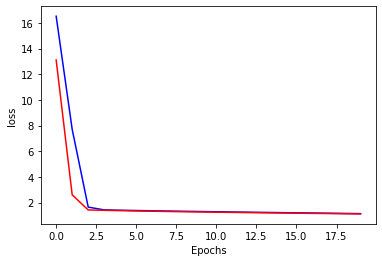

In [27]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

2. Create a graph showing your accuracy in relation to the number of epochs.

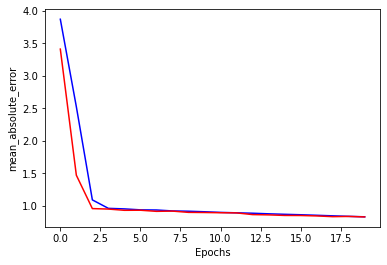

In [28]:
# Visualization of accuracy training 
plt.plot(history.history["mean_absolute_error"], color="b")
plt.plot(history.history["val_mean_absolute_error"], color="r")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epochs")
plt.show()

In [29]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir logs --port=0004

3. Write to file the weights on the embedding layer and the 1000 most common words registered by the tokenizer. You can help yourself to the code in the code embedding demonstration.

In [30]:
vocab = [value for value in tokenizer.index_word.values()]
vocab = vocab[:1000]
weights = model.get_layer('embedding').get_weights()[0]

log_dir = "/content/logs/embed"
os.makedirs(log_dir, exist_ok=True)
out_v = io.open(log_dir+"/vectors.tsv", 'w', encoding='utf-8')
out_m = io.open(log_dir+"/metadata.tsv", 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

4. Go to [the embedding projector](https://projector.tensorflow.org/) in order to visualize the embedding, what do you think?

## Classification

In [31]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain-1))
val = tf.data.Dataset.from_tensor_slices((xval, yval-1))
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [32]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(5, activation="softmax")
])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 443, 8)            8008      
                                                                 
 global_average_pooling1d_1   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 8,237
Trainable params: 8,237
Non-trainable params: 0
_________________________________________________________________


In [34]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.MeanAbsoluteError()])

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs2")

In [36]:
history = model.fit(train_batch, 
                    epochs=100, 
                    validation_data=val_batch,
                    callbacks=[tensorboard_callback])

Epoch 1/100
93/93 [==============================] - 1s 5ms/step - loss: 1.5274 - sparse_categorical_accuracy: 0.5307 - mean_absolute_error: 2.9742 - val_loss: 1.4055 - val_sparse_categorical_accuracy: 0.5687 - val_mean_absolute_error: 2.9625
Epoch 2/100
93/93 [==============================] - 0s 5ms/step - loss: 1.2727 - sparse_categorical_accuracy: 0.5791 - mean_absolute_error: 2.9742 - val_loss: 1.2259 - val_sparse_categorical_accuracy: 0.5687 - val_mean_absolute_error: 2.9625
Epoch 3/100
93/93 [==============================] - 0s 4ms/step - loss: 1.2087 - sparse_categorical_accuracy: 0.5791 - mean_absolute_error: 2.9742 - val_loss: 1.2164 - val_sparse_categorical_accuracy: 0.5687 - val_mean_absolute_error: 2.9625
Epoch 4/100
93/93 [==============================] - 0s 4ms/step - loss: 1.2022 - sparse_categorical_accuracy: 0.5791 - mean_absolute_error: 2.9742 - val_loss: 1.2098 - val_sparse_categorical_accuracy: 0.5687 - val_mean_absolute_error: 2.9625
Epoch 5/100
93/93 [=========

In [37]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir logs2 --port=0007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
